In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling import models, fitting
from specutils.fitting import fit_lines
from scipy.stats import normaltest

C:\Users\petri\AppData\Local\Temp\ipykernel_6060\1230022147.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time[['vHI','fHI','fBHI']] = time['vHI'].str.split(expand=True)


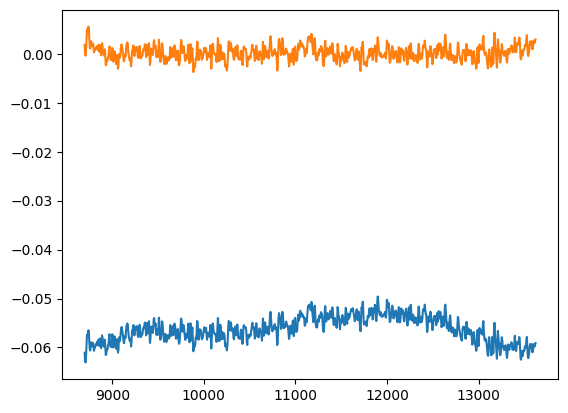

In [3]:
file = 'mangaHI-8084-3704.csv'

timeSeries = pd.read_csv(file, names = ('vHI','fHI', 'fBHI'))

time = timeSeries[22:-1]
time[['vHI','fHI','fBHI']] = time['vHI'].str.split(expand=True)
time = time.reset_index(drop=True).astype(float)

plt.plot(time['vHI'], time['fBHI'])
plt.plot(time['vHI'], time['fHI'])

plt.show()

Data can't be described by a single Gaussian fit -> we use a double gaussian fit
Spectral Line Region -> Mean: -0.000246, Std Dev: 0.001843
Non-Spectral Line Region -> Mean: 0.000141, Std Dev: 0.001405
Percentage Difference in Mean: -274.44%
Percentage Difference in Std Dev: 31.14%


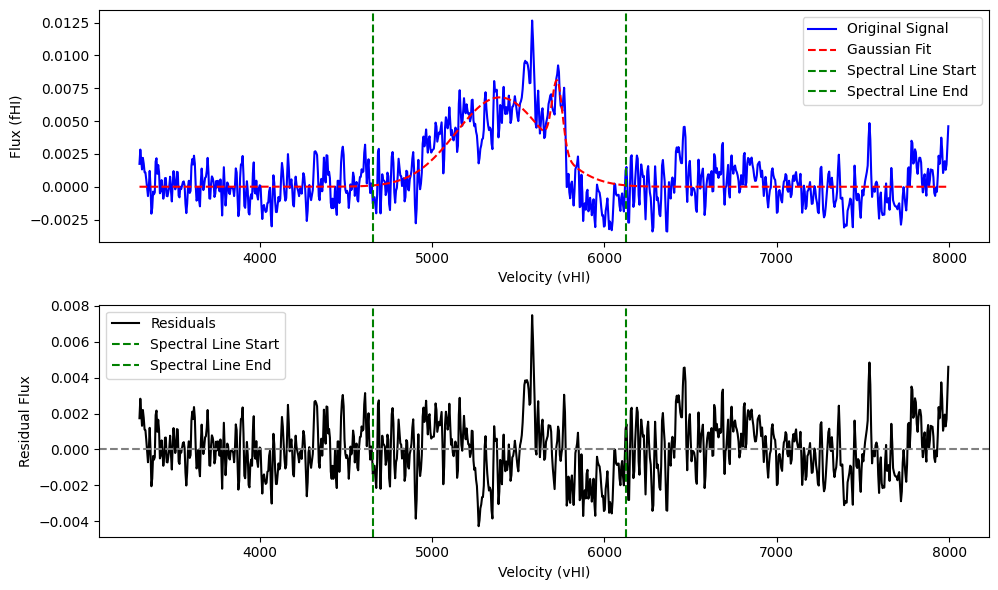

In [6]:
file = 'mangaHI-7443-1902.csv'
timeSeries = pd.read_csv(file, names=['vHI', 'fHI', 'fBHI'])

time = timeSeries[22:-1].copy()
time[['vHI', 'fHI', 'fBHI']] = time['vHI'].str.split(expand=True)
time = time.reset_index(drop=True).astype(float)

x = time['vHI'].values
y = time['fHI'].values

# Perform normality test to check if a single Gaussian is sufficient
stat, p_value = normaltest(y)

# Fit a single Gaussian first
g_init = models.Gaussian1D(amplitude=max(y), mean=np.median(x), stddev=10)
fitter = fitting.LevMarLSQFitter()
g_fit = fitter(g_init, x, y)

# If the normality test fails attempt a double Gaussian fit
if p_value < 0.05:
    print("Data can't be described by a single Gaussian fit -> we use a double gaussian fit")
    g_init = models.Gaussian1D(amplitude=max(y), mean=np.median(x), stddev=10) + \
             models.Gaussian1D(amplitude=max(y)/2, mean=np.median(x) + 10, stddev=10)
    g_fit = fitter(g_init, x, y)

# Subtract Gaussian fit from original signal
residuals = y - g_fit(x)

# Identify spectral line region based on nonzero values of the Gaussian fit
line_indices = np.where(g_fit(x) > 0.0001)[0]  # Indices where the fit is (practically) nonzero
non_line_indices = np.setdiff1d(np.arange(len(x)), line_indices)  # Everything else

# Compute noise statistics
mean_line = np.mean(residuals[line_indices]) if len(line_indices) > 0 else np.nan
std_line = np.std(residuals[line_indices]) if len(line_indices) > 0 else np.nan

mean_non_line = np.mean(residuals[non_line_indices]) if len(non_line_indices) > 0 else np.nan
std_non_line = np.std(residuals[non_line_indices]) if len(non_line_indices) > 0 else np.nan

# Compute percentage differences
if std_non_line > 0:
    std_diff_percentage = ((std_line - std_non_line) / std_non_line) * 100
else:
    std_diff_percentage = np.nan

if mean_non_line != 0:
    mean_diff_percentage = ((mean_line - mean_non_line) / abs(mean_non_line)) * 100
else:
    mean_diff_percentage = np.nan

# Print results
print(f"Spectral Line Region -> Mean: {mean_line:.6f}, Std Dev: {std_line:.6f}")
print(f"Non-Spectral Line Region -> Mean: {mean_non_line:.6f}, Std Dev: {std_non_line:.6f}")
print(f"Percentage Difference in Mean: {mean_diff_percentage:.2f}%")
print(f"Percentage Difference in Std Dev: {std_diff_percentage:.2f}%")

# Plot results
plt.figure(figsize=(10, 6))

# Plot original signal and Gaussian fit
plt.subplot(2, 1, 1)
plt.plot(x, y, 'b-', label='Original Signal')
plt.plot(x, g_fit(x), 'r--', label='Gaussian Fit')

if len(line_indices) > 0:
    plt.axvline(x[line_indices[0]], color='g', linestyle='--', label="Spectral Line Start")
    plt.axvline(x[line_indices[-1]], color='g', linestyle='--', label="Spectral Line End")

plt.xlabel("Velocity (vHI)")
plt.ylabel("Flux (fHI)")
plt.legend()

# Plot residuals
plt.subplot(2, 1, 2)
plt.plot(x, residuals, '-k', label='Residuals')
plt.axhline(0, color='gray', linestyle='--')

# Mark spectral line region in residuals
if len(line_indices) > 0:
    plt.axvline(x[line_indices[0]], color='g', linestyle='--', label="Spectral Line Start")
    plt.axvline(x[line_indices[-1]], color='g', linestyle='--', label="Spectral Line End")

plt.xlabel("Velocity (vHI)")
plt.ylabel("Residual Flux")
plt.legend()

plt.tight_layout()
plt.show()